<a href="https://colab.research.google.com/github/ricky-kiva/dl-deep-tf-cnn/blob/main/4_a1_sign_language_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sign Language Multiclass Classification**

Download dataset: [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist)

In [1]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 110MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 143MB/s] 


Reference the csv

In [2]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

Inspect the first 2 rows in the CSV

In [3]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

Make csv data parser function

In [4]:
import csv
import numpy as np

def parse_data_from_input(filename):
  with open(filename) as file:
    csv_reader = csv.reader(file, delimiter=',')

    header = next(csv_reader)

    labels = []
    images = []

    for data in csv_reader:
      labels.append(data[0])
      image = np.array(data[1:]).reshape((28, 28)).astype('float64')
      images.append(image)

    labels = np.array(labels).astype('float64')
    images = np.array(images)

    return images, labels

Parse the CSV

In [5]:
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


Visualize the numpy arrays (the images)

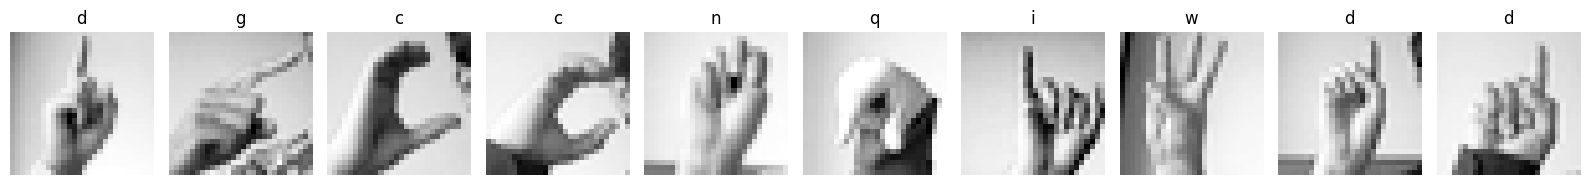

In [6]:
import matplotlib.pyplot as plt
import string
from tensorflow.keras.preprocessing.image import array_to_img

def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    # expand dimension to the inner arrays (axis=-1), so it will become grayscale image (28, 28, 1)
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)

    ax = axes[k]
    ax.imshow(img, cmap='Greys_r')
    ax.set_title(f'{letters[int(training_labels[k])]}')
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

Create image generators

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_val_generators(training_images, training_labels, validation_images, validation_labels):

  training_images = np.expand_dims(training_images, axis=-1)
  validation_images = np.expand_dims(validation_images, axis=-1)

  train_datagen = ImageDataGenerator(rescale=1./255.,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32)

  validation_datagen = ImageDataGenerator(rescale=1./255.)

  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32)

  return train_generator, validation_generator

Instantiate the generators

In [8]:
train_generator, validation_generator = train_val_generators(training_images,
                                                             training_labels,
                                                             validation_images,
                                                             validation_labels)

Check the generators

In [9]:
print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


Add function to create model

In [36]:
import tensorflow as tf

def create_model():

  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1024, activation='relu'),
      tf.keras.layers.Dense(26, activation='softmax')
  ])

  model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

Create the model

In [37]:
model = create_model()

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 13, 13, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 11, 11, 512)       590336    
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 5, 5, 512)         0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_8 (Dropout)         (None, 12800)            

Train the model

In [38]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 18s 19ms/step - loss: 2.6079 - accuracy: 0.2006 - val_loss: 1.3726 - val_accuracy: 0.5788
Epoch 2/15
858/858 [==============================] - 17s 20ms/step - loss: 1.5305 - accuracy: 0.5046 - val_loss: 0.7548 - val_accuracy: 0.7377
Epoch 3/15
858/858 [==============================] - 17s 20ms/step - loss: 1.0127 - accuracy: 0.6636 - val_loss: 0.4145 - val_accuracy: 0.8423
Epoch 4/15
858/858 [==============================] - 16s 19ms/step - loss: 0.7475 - accuracy: 0.7525 - val_loss: 0.2810 - val_accuracy: 0.8988
Epoch 5/15
858/858 [==============================] - 16s 19ms/step - loss: 0.6070 - accuracy: 0.7969 - val_loss: 0.2456 - val_accuracy: 0.9117
Epoch 6/15
858/858 [==============================] - 16s 19ms/step - loss: 0.5020 - accuracy: 0.8338 - val_loss: 0.1708 - val_accuracy: 0.9413
Epoch 7/15
858/858 [==============================] - 17s 20ms/step - loss: 0.4515 - accuracy: 0.8512 - val_loss: 0.0864 - val_accuracy:

Evaluate the model

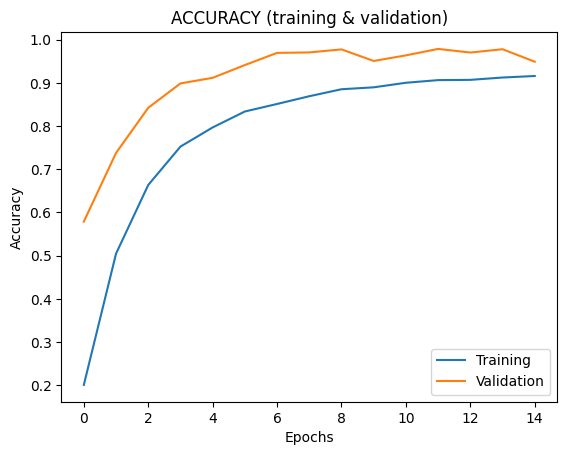

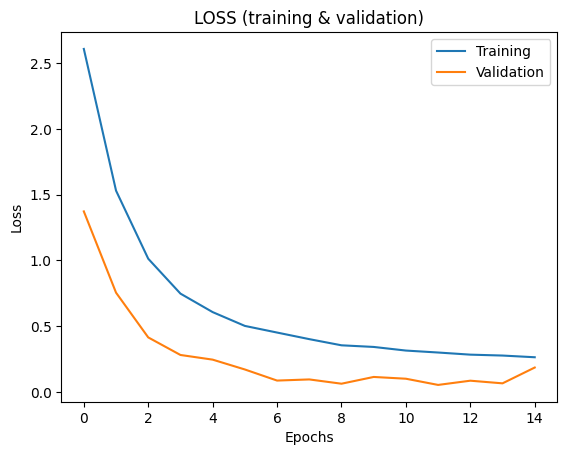

In [39]:
import matplotlib.pyplot as plt

# get data from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# get epochs data
epochs = range(len(acc))

# plot accuracy data
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('ACCURACY (training & validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plot loss data
plt.figure()
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.title('LOSS (training & validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()